In [1]:
import numpy as np
import scipy.stats as stats
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

# Gaussian Mixture Models (GMM) and Expectation Maximization (EM)

### Define ground truth GMM parameters for simulation 
- Choose # Random Variables (M)
- Choose # Gaussians (K)
- Draw random $\mu$, $\Sigma$, $\phi$
- Draw samples from the multivariate GMM distribution

In [2]:
M = 2 # Number of "Features" for the multivariate GMM distribution
K = 3 # Number of Gaussians
limits = np.array([-5, 5]) # Define limits for mu, sigma 


In [25]:
def draw_GMM_parameters(M,K,limits):
    """
    This function draws random mu, sigma, and phi for the gaussian mixture model. 
    Inputs: M - Number of "Features" for the multivariate GMM distribution
            K - Number of Gaussians
            limits - limits for drawing mu
    """
    
    lower_lim = limits[0]
    upper_lim = limits[1]

    mu               = lower_lim + (upper_lim - lower_lim) * np.random.rand(K,M)
    sigma_tmp        = lower_lim + (upper_lim - lower_lim) * np.random.rand(M,M,K) 
    
    sigma            = np.zeros((M,M,K))
    
    for k in range(K):
        sigma[1,0,k] = sigma[0,1,k];
        sigma[:,:,k] = np.matmul(sigma_tmp[:,:,k], sigma_tmp[:,:,k].T)


    random_weights   = np.random.rand(K,1)
    phi              = random_weights / np.sum(random_weights)
    
    return mu, sigma, phi

In [26]:
def sample_from_GMM(mu, sigma, phi, n_samples, *args, **kwargs):
    
    # get plot_flag
    
    
    K = sigma.shape[-1] # number of gaussians
    M = sigma.shape[0] # number of features
    
    data = np.zeros((n_samples,M))
    g_idx  = np.zeros((n_samples,), dtype=int)
    
    for n in range(n_samples):
        
        # draw gaussian index - with probabilities of each gaussian corresponding to phi
        g_idx[n] =  np.random.choice(np.arange(K), p = phi.reshape(-1))
        
        # draw sample from gaussian g_idx
        data[n,:] = np.random.multivariate_normal(mean = mu[g_idx[n],:], cov = sigma[:,:,g_idx[n]], size = 1)
    
    plot_flag = kwargs.get('plot_flag')
    if plot_flag:
        plt.figure(figsize = (7,7))
        sns.set_style('white')
        sns.scatterplot(data[:,0],data[:,1],hue = g_idx,palette = "rainbow")
        #sns.jointplot(data[:,0],data[:,1],kind = 'kde')
        #for k in range(K):
        #    plt.scatter(mu[k,0],mu[k,1],s = 300,color = 'k',marker = 'x')
        plt.show()


    return data, g_idx

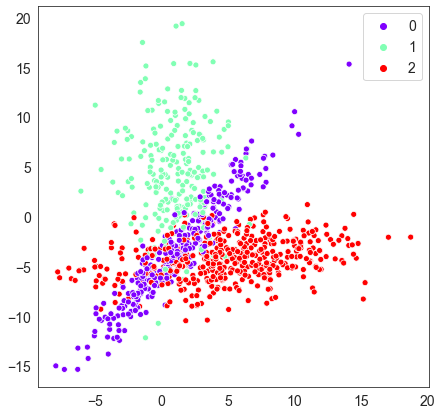

In [85]:
mu, sigma, phi          = draw_GMM_parameters(M,K,limits)
data, true_gaussian_idx = sample_from_GMM(mu, sigma, phi, n_samples = 1000,plot_flag = True)

### Estimate GMM parameters using the Expectation - Maximization Algorithm
- Define EM hyper-parameters: K, stopping condition: tolerance/ # of iterations
- Initialize estimates for $\mu$, $\Sigma$, $\phi$
- Call EM function

##### EM Stopping Condition: 
$$\lVert log(p(\mathbf{x}^{(i)}|\mathbf{\theta}^{(i)})) - log(p(\mathbf{x}^{(i-1)}|\mathbf{\theta}^{(i-1)})) \rVert < \epsilon$$

In [100]:
K_est     = 3    # estimated # of Gaussians
tol       = 1e-3 # tolerance for stopping condition
n_iter    = 30
plot_flag = True

mu0, sigma0, phi0 = draw_GMM_parameters(M,K_est,limits)

In [101]:
def EM_algorithm(data, mu0, sigma0, phi0, K_est, tol, n_iter):

    model_params = {'mu': mu0, 'sigma': sigma0, 'phi': phi0, 'k': K_est} # initialize model parameters dictionary

    log_likelihood = np.zeros((1,n_iter)); # initialize log-likelihood per iteration
    
    
    for iter in range(n_iter):
        
        # Expectation step - per sample
        hidden_params = expectation(data, model_params);
                   
        # Maximization step - per Gaussian
        model_params, log_likelihood[:,iter] = maximization(data, model_params, hidden_params);
        
        print("Iteration #", str(iter) ," - Log-Likelihood = ", str(log_likelihood[:,iter]))
        print(" ")
     
        # Check convergence
        if iter > 1 and np.linalg.norm(log_likelihood[:,iter] - log_likelihood[:,iter-1]) < tol:
            return model_params, log_likelihood

    return model_params, log_likelihood

In [102]:
def expectation(data, model_params):
    
    # Get sizes
    K = model_params['k']
    N = data.shape[0]

    # Get model parameters for the K_est Gaussians
    mu    = model_params['mu'];
    sigma = model_params['sigma'];
    phi   = model_params['phi'];
        
    # Initialize hidden variables z (gaussian index) in Q. 
    # Qij = P[z = k | x(n)]
    
    Q = np.zeros((K,N))

    for k in range(K):

        for n in range(N):
            
            # Calculate normalization factor
            inv_norm_factor = 0
            
            for kk in range(K):
                inv_norm_factor = (inv_norm_factor 
                                    + phi[kk] * stats.multivariate_normal(mu[kk,:],sigma[:,:,kk]).pdf(data[n,:]) )
            
            # Evaluate Q for sample n of gaussian k:  P[z = k | x(n)]
            Q[k,n] = phi[k] * stats.multivariate_normal(mu[k,:],sigma[:,:,k]).pdf(data[n,:]) / inv_norm_factor 

    
    hidden_params = {"Q":Q};
    
    return hidden_params

In [103]:
def maximization(data, model_params, hidden_params):

    # Get sizes
    K = model_params['k']
    N = data.shape[0]
    M = data.shape[1]

    # Get latent variables in Q
    Q    = hidden_params["Q"]

    # Initialize outputs
    mu_est    = np.zeros((K,M))
    sigma_est = np.zeros((M,M,K))
    phi_est   = np.zeros((K,1))

    # Maximize likelihood of the data by finding better estimates of the model parameters (mu, sigma, phi)
    for k in range(K):
        phi_est[k]  = 1/N * np.sum( Q[k,:] )
       
        mu_est[k,:]   = np.matmul(Q[k,:], data) / np.sum( Q[k,:] )
        
        sigma_k = np.zeros((M,M))                   
        
        for n in range(N):
            X_n = data[n,:] - mu_est[k,:]
            sigma_k = sigma_k + (Q[k,n] / np.sum(Q[k,:]) ) * np.outer(X_n,X_n)

        sigma_est[:,:,k] = sigma_k

        assert all(np.linalg.eigvals(sigma_est[:,:,k])> 0), "sigma_est is not positive semi-definite" 
    

    # Calculate likelihood of the data w.r.t the model parameters
    likelihood = 0  
        
    for n in range(N):
        for k in range(K):
            likelihood = (likelihood + 
                        phi_est[k] * stats.multivariate_normal(mu_est[k,:],sigma_est[:,:,k]).pdf(data[n,:]))

    
    log_likelihood = np.log(likelihood)

    
    # Save updated model parameters
    model_params['mu']    = mu_est
    model_params['sigma'] = sigma_est
    model_params['phi']   = phi_est
    
    return model_params, log_likelihood

In [106]:
model_params, log_likelihood = EM_algorithm(data, mu0, sigma0, phi0, K_est, tol, n_iter = 30)

Iteration # 0  - Log-Likelihood =  [1.47118739]
 
Iteration # 1  - Log-Likelihood =  [1.5229985]
 
Iteration # 2  - Log-Likelihood =  [1.56299737]
 
Iteration # 3  - Log-Likelihood =  [1.58997083]
 
Iteration # 4  - Log-Likelihood =  [1.60584854]
 
Iteration # 5  - Log-Likelihood =  [1.61392288]
 
Iteration # 6  - Log-Likelihood =  [1.61926845]
 
Iteration # 7  - Log-Likelihood =  [1.62506763]
 
Iteration # 8  - Log-Likelihood =  [1.63030274]
 
Iteration # 9  - Log-Likelihood =  [1.63465534]
 
Iteration # 10  - Log-Likelihood =  [1.63829364]
 
Iteration # 11  - Log-Likelihood =  [1.64138273]
 
Iteration # 12  - Log-Likelihood =  [1.64404263]
 
Iteration # 13  - Log-Likelihood =  [1.64639129]
 
Iteration # 14  - Log-Likelihood =  [1.6485788]
 
Iteration # 15  - Log-Likelihood =  [1.65080681]
 
Iteration # 16  - Log-Likelihood =  [1.65334343]
 
Iteration # 17  - Log-Likelihood =  [1.65653886]
 
Iteration # 18  - Log-Likelihood =  [1.66083603]
 
Iteration # 19  - Log-Likelihood =  [1.6668

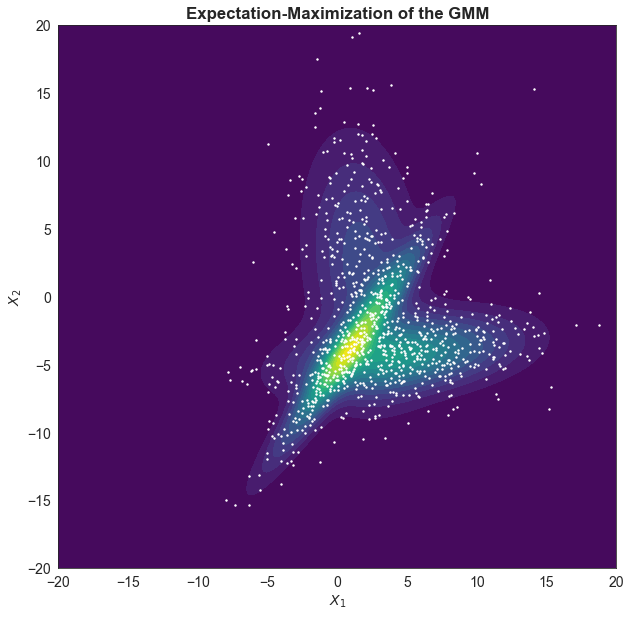

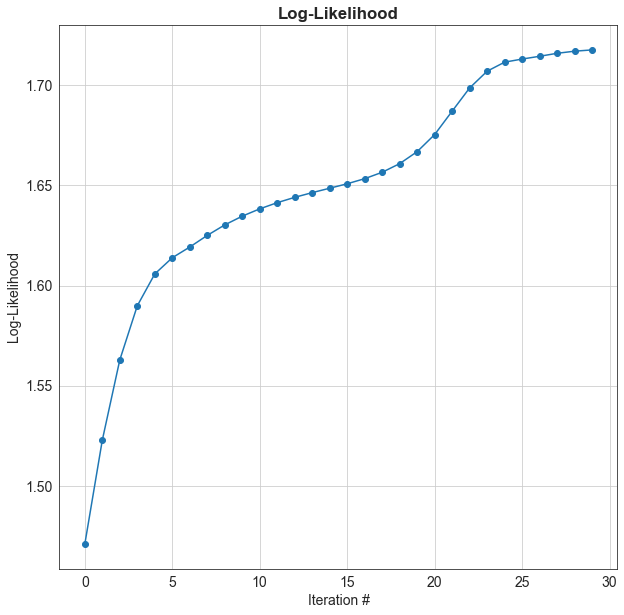

In [107]:
## plot Results
plt.figure(figsize = (10,10))

plt.rc('font', size=14)


plt.grid(which = 'both')
plt.xlabel('$X_{1}$')
plt.ylabel('$X_{2}$');
plt.title('Expectation-Maximization of the GMM', fontweight = 'bold');

x     = np.linspace(-20,20,500)
y     = np.linspace(-20,20,500)
X,Y   = np.meshgrid(x, y)
mu    = model_params['mu'];
sigma = model_params['sigma'];

phi = model_params['phi']
P = 0
for k in range(K):
    P = P + phi[k] * stats.multivariate_normal(mu[k,:],sigma[:,:,k]).pdf(np.vstack((X.flatten(),Y.flatten())).T) 
plt.contourf(X,Y,P.reshape(500,500),levels = 20,cmap = 'viridis')
plt.scatter(data[:,0],data[:,1],color = 'white', s = 2)
plt.show()
    

plt.figure(figsize = (10,10))
plt.xlabel('Iteration #');
plt.ylabel('Log-Likelihood');
plt.title('Log-Likelihood',fontweight = 'bold');
plt.plot(np.arange(n_iter),log_likelihood.flatten(),marker = 'o')
plt.grid()
plt.show()